In [1]:
import numpy as np 
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
import datetime as dt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
file_path = './data.csv'  
df = pd.read_csv(file_path)

def tidy_data(row):
    
    ########################################################
    ## Pick the level of item detail we group things into ##
    ########################################################
    
    ##parts = [row['SUB Category2'], row['SUB Category'], row['Category']]
    parts = [row['SUB Category'], row['Category']]
    parts = [row['Category']]


    non_default_parts = list(dict.fromkeys([str(part).lower() for part in parts if pd.notna(part) and part.lower() != 'default']))
    return ' '.join(non_default_parts)

df['Item'] = df.apply(tidy_data, axis=1)

all_items = df['Item'].dropna() 
unique_items = all_items.unique()
df_grouped = df.groupby('OrderHeaderNumber').agg({'Item': list}).reset_index()
df_grouped = df_grouped.rename(columns={'Item': 'Products'})
df_grouped['Size'] = df_grouped['Products'].apply(len)
df_grouped

,OrderHeaderNumber,Products,Size
0,103008,[tops],1
1,103010,"[trousers, trousers, trousers, trousers, trous...",9
2,103011,"[underwear, socks, tops, tops, sweats]",5
3,103012,"[skirts, trousers, skirts, skirts, trousers, s...",7
4,103014,[jeans],1
...,...,...,...
113027,IN0285148,[shirts],1
113028,IN0285149,"[shirts, knitwear, knitwear, knitwear]",4
113029,IN0285150,"[sweats, tops, shirts]",3
113030,IN0285151,"[tops, knitwear, tops, trousers, tops]",5


In [3]:
data = list(df_grouped["Products"])

te = TransactionEncoder()
te_data = te.fit(data).transform(data)
df = pd.DataFrame(te_data,columns=te.columns_).astype(bool)
df

,accessories,bags,blazers,dresses,hats,jeans,knitwear,outerwear,shirts,shoes,shorts,skirts,socks,sunglasses,sweats,tops,trousers,underwear
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,True
3,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
4,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113027,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
113028,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False
113029,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False
113030,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False


In [4]:
# Apriori
freq_items = apriori(df, min_support = 0.05, use_colnames = True, verbose = 1)
freq_items.sort_values("support", ascending = False)

# Assuming you have already performed the Apriori analysis and sorted the freq_items DataFrame
freq_items_sorted = freq_items.sort_values("support", ascending=False)
freq_items_sorted.to_csv('freq_styles.csv', index=False)

Processing 8 combinations | Sampling itemset size 43


In [5]:
freq_items

,support,itemsets
0,0.050543,(dresses)
1,0.197077,(jeans)
2,0.221902,(knitwear)
3,0.064415,(outerwear)
4,0.261997,(shirts)
5,0.085109,(sweats)
6,0.527187,(tops)
7,0.308541,(trousers)
8,0.067441,(underwear)
9,0.052330,"(jeans, knitwear)"


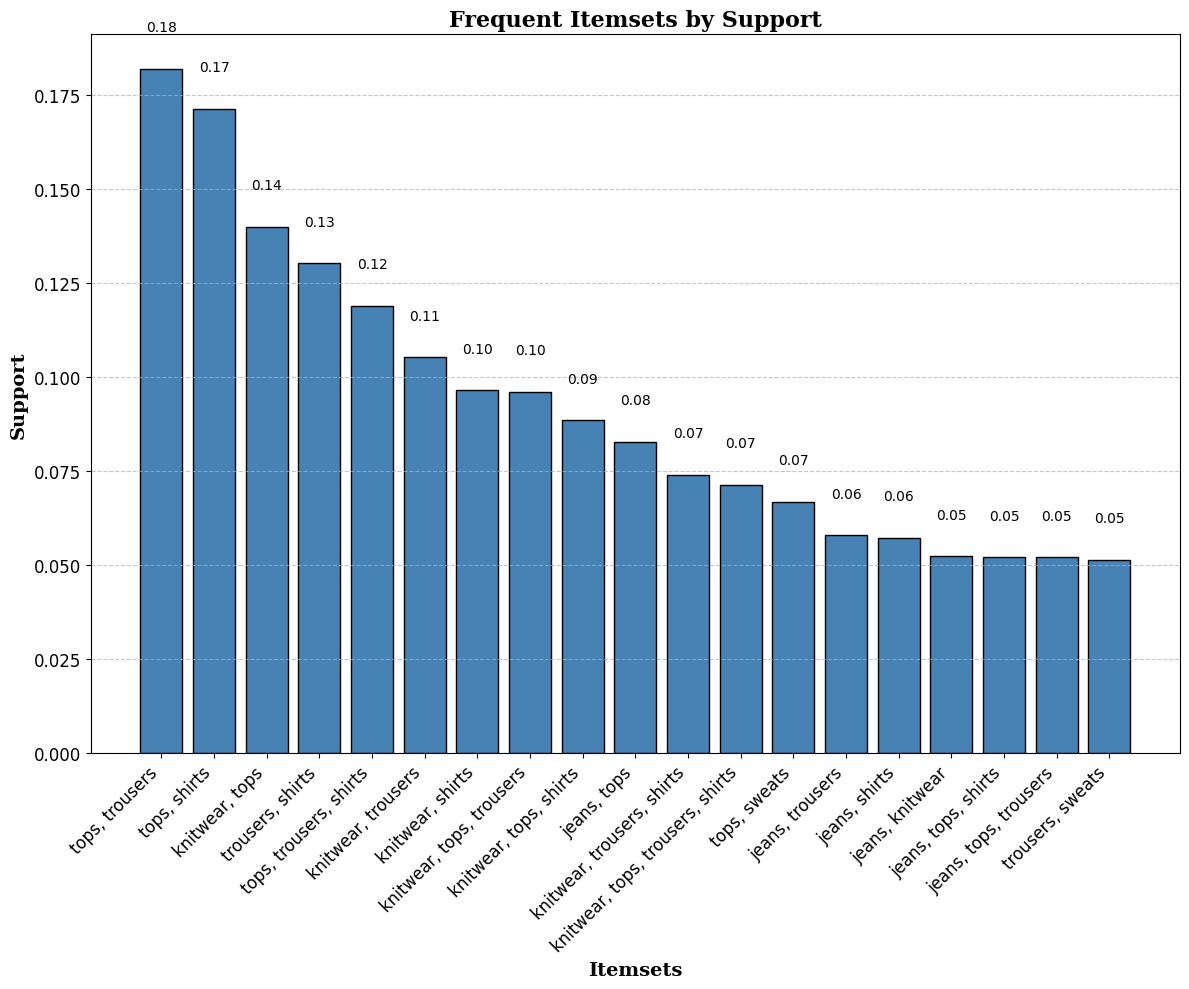

In [ ]:
# Sort the DataFrame by support
freq_items_sorted = freq_items.sort_values("support", ascending=False)

# Clean the itemsets for visualization
freq_items_sorted['itemsets_cleaned'] = freq_items_sorted['itemsets'].apply(lambda x: ', '.join(list(x)))

# Remove rows where the length of itemsets is less than 2
freq_items_sorted = freq_items_sorted[freq_items_sorted['itemsets'].apply(lambda x: len(x) >= 2)]

# Bar Chart with cleaned itemsets
plt.figure(figsize=(12, 10))
plt.bar(freq_items_sorted['itemsets_cleaned'], freq_items_sorted['support'], color='steelblue', edgecolor='black')
plt.title('Frequent Itemsets by Support', fontsize=16, fontweight='bold', fontfamily='serif')
plt.xlabel('Itemsets', fontsize=14, fontweight='bold', fontfamily='serif')
plt.ylabel('Support', fontsize=14, fontweight='bold', fontfamily='serif')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add bar annotations
for index, value in enumerate(freq_items_sorted['support']):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', fontsize=10)

plt.savefig('graph_name.png', format='png', dpi=300)
plt.show()